In [1]:
import drnb.embed.pipeline as pl

/home/james/dev/drnb-plugin/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SpaceMAP ([paper](https://proceedings.mlr.press/v162/zu22a.html), [github](https://github.com/zuxinrui/SpaceMAP)) is a variant of UMAP which attempts to automatically determine the similarity kernel parameters which best match the intrinsic dimensionality of the original data. According to the paper, the main ways it does so are:

1. Calculate a per-point "local" intrinsic dimensionality by the MLE method of [Levina and Bickel](https://papers.nips.cc/paper/2004/hash/74934548253bcab8490ebd74afed7031-Abstract.html) using the 20 ($k_{\mathrm{near}}$) nearest neighbors of each observation.
2. Calculate a "global" estimate of intrinsic dimensionality using the method of [MacKay and Ghahramani](http://www.inference.org.uk/mackay/dimension/) using the 70 ($k_{\mathrm{mid}}$) nearest neighbors of each observation. The MacKay-Ghahramani method is a way to combine the Levina-Bickel local estimates (except using more nearest neighbors in this case).
3. Do t-SNE-style calibration for the "near" field, except instead of using a similarity function exponential in the square of the ambient input distances $r_{ij}$, (i.e. a Gaussian), use the square of the "equivalent extended distance" (EED) $r_{ij}^{D_{\mathrm{local},i}/D_{\mathrm{global}}}$ where $D_{\mathrm{local},i}$ and $D_{\mathrm{global}}$ are the estimates for the local and global intrinsic dimensionalities respectively. As $D_{\mathrm{local}}$ is a per-point estimate, I put a $i$ subscript in there although it's not in the paper. t-SNE-style symmetrization is also carried out.
4. For the neighbors in the "mid" field (so by default that's neighbors 21-70), they are calibrated with a Gaussian function, but instead of using the t-SNE approach of using perplexity to determine bandwidths, the UMAP-style approach of using $\log_2 \left(k_{\mathrm{mid}}\right)$ as the target is employed. To keep the similarity values smooth, the Gaussian is shifted so that the value at the first of the mid-neighbors is what it would be if it was part of the near-field calculation.
5. The output similarity kernel is also an exponential in the EED, with $D_{\mathrm{local},i}$ replaced by the output dimensionality: $d_{ij}^{D_{\mathrm{out}}/D_{\mathrm{global}}}$.

There is no PyPI package for SpaceMAP and the source code seems to contain a lot of different research variants so what follows is my own implementation with the following notable differences:

1. As noted by by [Böhm and co-workers](https://www.jmlr.org/papers/v23/21-0055.html) you can use binary affinities for the input kernel and it doesn't make much difference to the output (the earliest prior use of binary affinities for t-SNE I know of is by [Yang and co-workers](https://proceedings.mlr.press/v38/yang15a.html) but they don't actively compare their results with any derived for Gaussian-based affinities). So none of steps 3-4 should be necessary. So I don't use them. This means we don't directly use $D_{\mathrm{local}, i}$ but a similar calculation is needed for $D_{\mathrm{global}}$ anyway.
2. The Levina-Bickel MLE intrinsic dimensionality estimator is pretty easy to implement, but my version gives different results for $D_{\mathrm{global}}$ to those reported in the SpaceMAP paper (in appendix A.7). I have compared my results to the implementation in the [scikit-dimension](https://github.com/j-bac/scikit-dimension) package and get agreement to several decimal places, so perhaps there is some difference in either the pre-processing of the datasets or nearest neighbor calculations (although looking in the SpaceMAP repo, we both use FAISS for the nearest neighbors calculations). Here are some comparative results along with results for 5 Gaussians of increasing dimension (with N = 10,000) so you can judge whether I have implemented the method correctly:


**dataset**|**me**|**SpaceMAP**
-----|-----|-----
gauss2D|2.02|N/A
gauss3D|3.05|N/A
gauss5D|5.02|N/A
gauss10D|9.22|N/A
gauss50D|28.54|N/A
mnist|12.72|8.8
fashion|13.48|9.3
coil20|4.75|3.3
tasic2018|33.99|16.7

(in the SpaceMAP paper, what I call the `mnist`, `fashion`, `coil20` and `tasic2018` datasets are referred to as `MNIST`, `Fashion-MNIST`, `COIL-20` and `RNA-Seq` respectively). 

Results for the Gaussians seem pretty good for up to 10D. The 50D results is very much an underestimate but it would perhaps be ambitious to get an accurate calculation in that case with only 10,000 points. For the datasets in the SpaceMAP paper, my estimates are substantially higher. I don't currently have an explanation for that. 

Also, it should be noted that the MLE results gave me *negative* values when using the cosine metric, so probably it's not suitable for angular metrics.

Below are the functions I used to generate this data, but to run this yourself you will need to run the equivalent notebooks in the `embed-pipeline` folder (e.g. [mnist.ipynb](https://github.com/jlmelville/drnb/blob/e010b85f5f9a2b2e9ee5de8ad98fa7e40d008295/notebooks/data-pipeline/mnist.ipynb) for `mnist`) and also install scikit-dimension yourself.

```python
import numpy as np

from drnb.dimension import mle_global
from drnb.neighbors import get_exact_neighbors


def drnbid(name, n_neighbors=70):
    nbrs = get_exact_neighbors(name, n_neighbors=n_neighbors + 1)
    return mle_global(nbrs.dist, n_neighbors=n_neighbors, remove_self=True)


# You will need to `pip install scikit-dimension` for this
# from skdim.id._MLE import MLE
def skid(name, n_neighbors=70, eps=1e-10):
    nbrs = get_exact_neighbors(name, n_neighbors=n_neighbors + 1)
    idx = nbrs.idx[:, 1:]
    dist = nbrs.dist[:, 1:]
    dist[dist < eps] = eps
    return (
        MLE().fit(np.zeros(dist.shape), precomputed_knn_arrays=(dist, idx)).dimension_
    )
```

## Low-dimensional Similarity Kernel

Assuming the output dimension, $D_{\mathrm{out}} = 2$ in the usual visualization case, then the output kernel for SpaceMAP is:

$$
w_{ij} = \exp \Bigl\{-\left[\left(d_{ij}^{2/D_{\mathrm{global}}}\right)^2\right]\Bigr\} = \exp \left(-d_{ij}^{4/D_{\mathrm{global}}}\right)
$$


## Cost Function

SpaceMAP uses the same cost function as UMAP. Using binary input affinities we can split the non-constant part of the cost function into the attractive term that only acts on the (symmetrized) nearest neighbors:

$$
C_{\mathrm{SpaceMAP}}^{+} = -\log w_{ij}
$$

and then the contrastive repulsive cost term that acts on sampled non-neighbors:

$$
C_{\mathrm{SpaceMAP}}^{-} =  -\log \left(1 - w_{ij}\right)
$$

The derivatives we need are as usual:

$$
\frac{\partial{C_{\mathrm{SpaceMAP}}^+}}{\partial{w_{ij}}} = -\frac{1}{w_{ij}}
$$

$$
\frac{\partial{C_{\mathrm{SpaceMAP}}^-}}{\partial{w_{ij}}} = -\frac{1}{1 - w_{ij}}
$$

$$
\frac{\partial{d_{ij}^2}}{\partial{\mathbf{y_i}}} = 2 \left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

So as SpaceMAP does not normalize the output affinities, to get the gradient $\partial{C_{\mathrm{SpaceMAP}}}/\partial{\mathbf{y_i}}$, we just need to plug in $\partial{w_{ij}}/\partial{d_{ij}^2}$, so it's probably best to we write the kernel as:

$$
w_{ij} = \exp\Bigl\{-\left[\left(d_{ij}^2\right)^{2/D_{\mathrm{global}}}\right]\Bigr\}
$$


The derivative is then:

$$
\frac{\partial{w_{ij}}}{\partial{d_{ij}^2}}
= -\frac{2}{D_{\mathrm{global}}} \left(d_{ij}^{2}\right)^{\frac{2}{D_{\mathrm{global}}} - 1} \exp \Bigl\{-\left[\left(d_{ij}^2\right)^ {2/D_{\mathrm{global}}} \right]\Bigr\}
= -\frac{2}{D_{\mathrm{global}}d_{ij}^{2}} \left(d_{ij}^{2}\right)^{2/D_{\mathrm{global}}} \exp \Bigl\{-\left[\left(d_{ij}^2\right)^ {2/D_{\mathrm{global}}} \right]\Bigr\}
$$

which simplifies in terms of $w_{ij}$ to:

$$
\frac{\partial{w_{ij}}}{\partial{d_{ij}^2}} = \frac{2}{D_{\mathrm{global}}d_{ij}^{2}} w_{ij} \log w_{ij}
$$

so the gradients are:

$$
\frac{\partial{C_{\mathrm{SpaceMAP}}^+}}{\partial{\mathbf{y_i}}} = -4\frac{\log w_{ij}}{\varepsilon + D_{\mathrm{global}}d_{ij}^{2}} \left(\mathbf{y_i} - \mathbf{y_j}\right)
$$


$$
\frac{\partial{C_{\mathrm{SpaceMAP}}^-}}{\partial{\mathbf{y_i}}} = -4\frac{w_{ij} \log w_{ij}}{\varepsilon + \left(1 - w_{ij}\right) D_{\mathrm{global}}d_{ij}^{2}} \left(\mathbf{y_i} - \mathbf{y_j}\right)
$$


where like UMAP, $\varepsilon$ is a small value (e.g. `0.001`) to avoid division by zero. From looking at the SpaceMAP source code, it's possible the value of $\varepsilon$ is smaller in that implementation (maybe `1e-15`?).

## Implementation

As far as I can tell the real version of SpaceMAP uses the same asynchronous SGD as UMAP does,
whereas my version accumulates the gradient in each iteration and uses the 
[Adam](https://arxiv.org/abs/1412.6980) optimizer. The `dglobal` parameter can be used to specify a 
value of $D_{\mathrm{global}}$, otherwise (`dglobal="auto"`), the MLE estimate is used.

## The SpaceMAP Implementation Doesn't Seem Exactly Like The Paper

The [SpaceMAP code at the time I looked at it](https://github.com/zuxinrui/SpaceMAP/blob/70ea371194194f25c2b78706ae928a67a13f7d6b/_spacemap.py) seems to do some slightly different things compared to the paper, including a slightly different way of calculating the intrinsic dimensions, including a correction for when the cosine metric is used. Also the output kernel uses per-point values related to $D_{\mathrm{global}}$ and the $k_{\mathrm{near}}$ input distance. This further affects the gradient calculations. I have produced output using the [MNIST example](https://github.com/zuxinrui/SpaceMAP/blob/70ea371194194f25c2b78706ae928a67a13f7d6b/main.py) that seems to be close to what is in the paper, although the example code uses $k_{\mathrm{mid}} = 700$ (not a typo, you really need to calculate 700 nearest neighbors), which is the recommended default of 1% of the dataset, according to the [README](https://github.com/zuxinrui/SpaceMAP/blob/70ea371194194f25c2b78706ae928a67a13f7d6b/README.md?plain=1#L19). Also, presumably because the low-dimensional kernel now indirectly uses the neighbor distance in its calculation, I did get worse results from the SpaceMAP repo output if the MNIST pixel values are not scaled to 0-1 beforehand. I *don't* use any scaling in my implementation (also this doesn't affect the estimation of $D_{\mathrm{global}}$)

Working backwards from what's in the code to the theoretical underpinnings is beyond me (the word "bayes" appears multiple times in the comments and variable names), so I have no expectations that the version I have written will look like what the SpaceMAP code produces.

## Some Results

`mnist` first. First, using `n_neighbors=70` to match the value of $k_{\mathrm{mid}}$ in the paper. I have set `verbose=True` so you can see that the calculated intrinsic dimensionality is logged.

[08:52:41] INFO     Getting dataset mnist                                            ]8;id=967992;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=55112;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#245\245]8;;\

[08:52:43] INFO     Embedding                                                        ]8;id=405385;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=650446;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#248\248]8;;\

[08:52:44] INFO     Running SpaceMAP                                                 ]8;id=637547;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py\spacemap.py]8;;\:]8;id=379366;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py#227\227]8;;\

[08:53:01] INFO     estimated intrinsic dimensionality = 12.72                        ]8;id=279402;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py\spacemap.py]8;;\:]8;id=279379;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py#78\78]8;;\

[08:55:59] INFO     Embedding completed                                              ]8;id=183062;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py\spacemap.py]8;;\:]8;id=497903;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py#230\230]8;;\

           INFO     Evaluating                                                       ]8;id=379073;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=734799;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#270\270]8;;\

           INFO     rte-5-euclidean                                                       ]8;id=237117;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=386534;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=662711;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=795465;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     Using triplets from triplets/mnist.5.1337.idx.npy                ]8;id=872704;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=831497;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#295\295]8;;\

           INFO     Also found corresponding euclidean distances                     ]8;id=728726;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=861596;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#298\298]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=492442;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=718259;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

[08:56:00] INFO     rpc-5-euclidean                                                       ]8;id=66154;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=132188;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=333339;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=74613;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     Using triplets from triplets/mnist.5.1337.idx.npy                ]8;id=932312;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=461673;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#295\295]8;;\

           INFO     Also found corresponding euclidean distances                     ]8;id=296832;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=139786;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#298\298]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=409978;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=944670;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     nnp-[15, 50, 150]-noself-euclidean                                    ]8;id=109570;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=342296;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

[08:56:01] INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=192322;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=699377;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-l28vvimh/request.json                              

           INFO     [faiss] request metric=euclidean n_neighbors=151                 ]8;id=624583;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=901340;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=342345;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=5973;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[08:56:17] INFO     Plotting                                                         ]8;id=272482;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=136008;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#280\280]8;;\

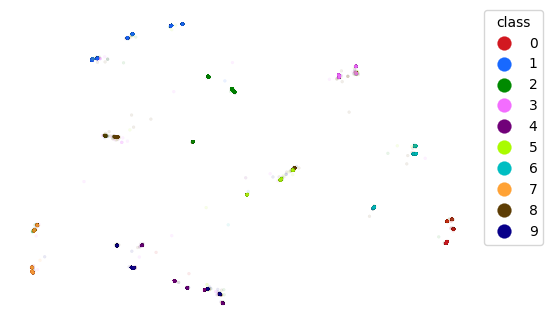

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.5970171428571429), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.30266497), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.028370476190476192), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.07487485714285716), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.1625457142857143), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [2]:
pl.standard_eval(
    method="spacemap", params=dict(n_neighbors=70), dataset="mnist", verbose=True
)

That does not look much like the result in the paper. Possibly using binary affinities with such a value of `n_neighbors` designed for the EED-calibrated affinities isn't wise. What if we drop to `n_neighbors=20`?

[08:56:19] INFO     Getting dataset mnist                                            ]8;id=549433;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=536448;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#245\245]8;;\

[08:56:21] INFO     Embedding                                                        ]8;id=869351;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=433314;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#248\248]8;;\

           INFO     Running SpaceMAP                                                 ]8;id=327095;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py\spacemap.py]8;;\:]8;id=810459;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py#227\227]8;;\

[08:56:31] INFO     estimated intrinsic dimensionality = 13.54                        ]8;id=887578;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py\spacemap.py]8;;\:]8;id=753171;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py#78\78]8;;\

[08:57:21] INFO     Embedding completed                                              ]8;id=479690;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py\spacemap.py]8;;\:]8;id=333775;file:///home/james/dev/drnb-plugin/src/drnb/embed/deprecated/spacemap.py#230\230]8;;\

           INFO     Evaluating                                                       ]8;id=7166;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=359311;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#270\270]8;;\

           INFO     rte-5-euclidean                                                       ]8;id=802588;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=7834;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=551122;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=964810;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     Using triplets from triplets/mnist.5.1337.idx.npy                ]8;id=820478;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=955712;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#295\295]8;;\

[08:57:22] INFO     Also found corresponding euclidean distances                     ]8;id=700329;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=257204;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#298\298]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=539214;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=629473;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     rpc-5-euclidean                                                       ]8;id=512923;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=836870;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=948466;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=155238;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     Using triplets from triplets/mnist.5.1337.idx.npy                ]8;id=886141;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=631886;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#295\295]8;;\

           INFO     Also found corresponding euclidean distances                     ]8;id=497775;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=44891;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#298\298]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=192076;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=4177;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#283\283]8;;\

           INFO     nnp-[15, 50, 150]-noself-euclidean                                    ]8;id=415450;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=782100;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=711708;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=560160;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-l9fnfla8/request.json                              

[08:57:23] INFO     [faiss] request metric=euclidean n_neighbors=151                 ]8;id=671588;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=615371;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=717944;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=572147;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[08:57:39] INFO     Plotting                                                         ]8;id=275568;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=177592;file:///home/james/dev/drnb-plugin/src/drnb/embed/pipeline.py#280\280]8;;\

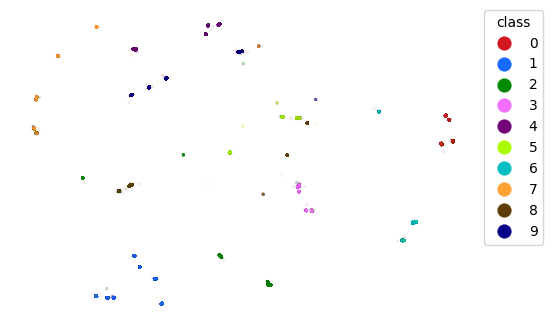

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6004342857142856), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.30321908), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.04520095238095238), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.10389314285714288), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.1996321904761905), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [3]:
pl.standard_eval(
    method="spacemap", dataset="mnist", params=dict(n_neighbors=20), verbose=True
)

Unfortunately results aren't changed match. In fact the estimate of intrinsic dimensionality goes *up*. What if we stick with the smaller number of neighbors and use the suggested value from the SpaceMAP paper for `mnist`, `dglobal_8.8`:

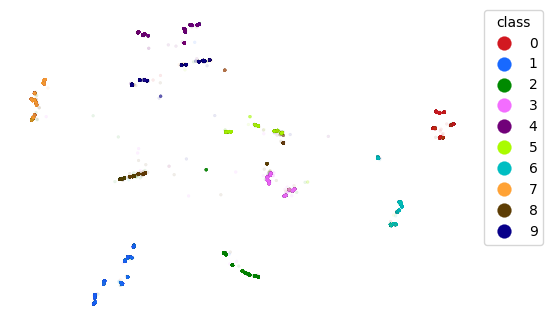

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.5998485714285714), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.303796), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.0772942857142857), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.15738028571428575), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.2581117142857143), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [4]:
pl.standard_eval(
    method="spacemap", dataset="mnist", params=dict(n_neighbors=20, dglobal=8.8)
)

Minor improvement, but clearly `dglobal=8.8` is still too high for my implementation. I'm going to halve that to `dglobal=4.4`:

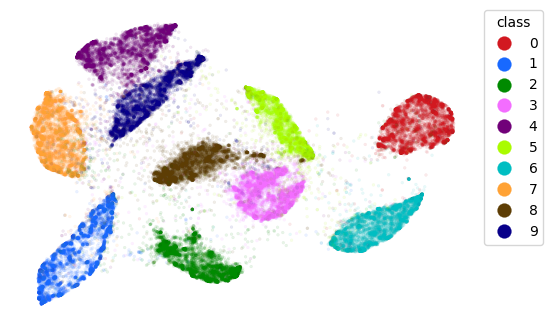

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6189257142857143), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.3617225), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.15347238095238094), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.21423657142857144), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.27564285714285713), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [5]:
pl.standard_eval(
    method="spacemap", dataset="mnist", params=dict(dglobal=4.4, n_neighbors=20)
)

At least this looks more like what I was expecting. Compared to UMAP, there are a *lot* of points in between the clusters. The `mnist` results in Figure 5 and 6 of the SpaceMAP paper do seem to show something like this, although it's not easy to tell and it doesn't seem as pronounced. However, having run and plotted the output with the SpaceMAP repo code, it *does* seem like this is characteristic of that output as well.

As `dglobal` seems so critical for good output, let's just check what going back to `n_neighbors=70` does with a more reasonable value of `dglobal`:

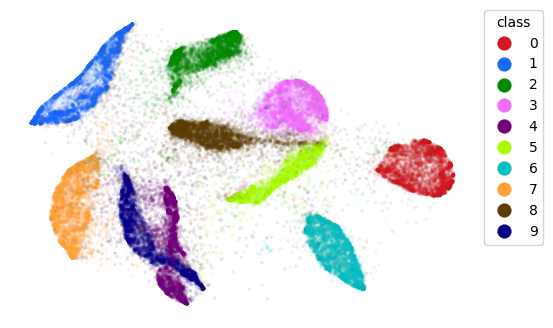

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6361742857142858), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.4228804), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.08941809523809524), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.16614800000000002), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.254088), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [6]:
pl.standard_eval(
    method="spacemap", dataset="mnist", params=dict(dglobal=4.4, n_neighbors=70)
)

Not a huge qualitative difference. Results for other datasets used in the SpaceMAP paper follow: `fashion`, `tasic2018` and `coil20`. In order to make the results easier to see I have stuck with `dglobal=4.4` rather than relying on either the `dglobal="auto"` results of using the values from the SpaceMAP paper which (except for `coil20`) would not give visually useful output with this version SpaceMAP. Also, I checked if `n_neighbors=70` has any effect on these datasets and there is once again not a big difference, so just the `n_neighbors=20` results are shown.

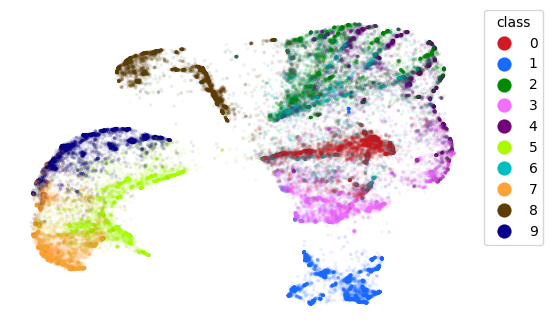

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7454828571428573), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.63007754), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.16354095238095237), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.23824914285714288), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.3093107619047619), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [7]:
pl.standard_eval(
    method="spacemap", dataset="fashion", params=dict(dglobal=4.4, n_neighbors=20)
)

[09:05:26] WARNING  UMAP graph has 3 components                                         ]8;id=134754;file:///home/james/dev/drnb-plugin/src/drnb/yinit.py\yinit.py]8;;\:]8;id=70467;file:///home/james/dev/drnb-plugin/src/drnb/yinit.py#290\290]8;;\

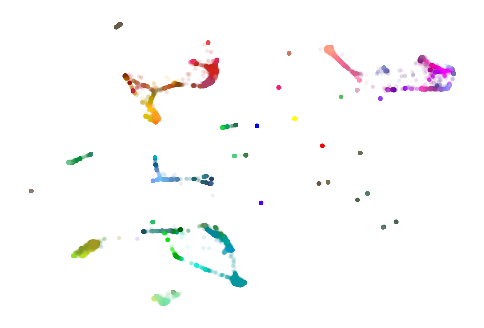

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.751943581563261), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.4441218), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.1611395628690566), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.30062883049282174), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.4542618867713318), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [8]:
pl.standard_eval(
    method="spacemap", dataset="tasic2018", params=dict(dglobal=4.4, n_neighbors=20)
)

[09:06:10] WARNING  UMAP graph has 3 components                                         ]8;id=572760;file:///home/james/dev/drnb-plugin/src/drnb/yinit.py\yinit.py]8;;\:]8;id=505903;file:///home/james/dev/drnb-plugin/src/drnb/yinit.py#290\290]8;;\

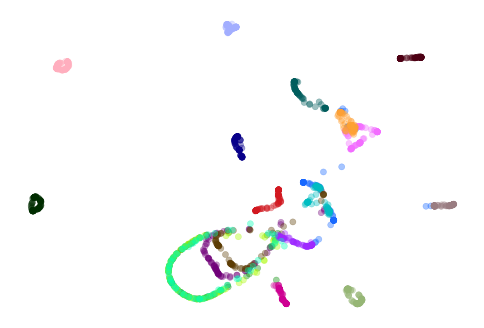

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6576388888888889), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.41321856), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.6573611111111112), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.6992638888888889), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.5012407407407408), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [9]:
pl.standard_eval(
    method="spacemap", dataset="coil20", params=dict(dglobal=4.4, n_neighbors=20)
)

Repeating this with `n_neighbors=70` doesn't make for a big difference. Looks like for these datasets, a `d_global` of around 4.0-5.0 works ok. Figure 4 in the SpaceMAP paper also shows a dataset very similar to the S-curve with a hole, used in [PaCMAP](https://arxiv.org/abs/2012.04456). In this they fix `dglobal=2.0`, so let's see how it works with `n_neighbors=20`:

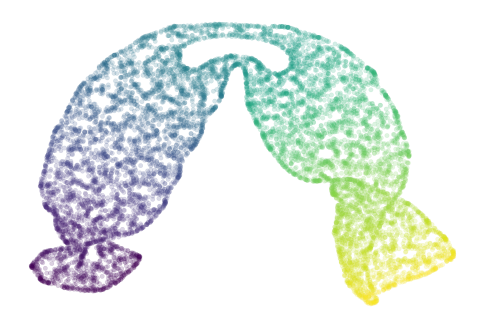

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7866596528143084), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.72691333), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.7578607750306856), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.8039495002630196), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.8300403296510608), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [10]:
pl.standard_eval(
    method="spacemap", dataset="scurvehole", params=dict(dglobal=2.0, n_neighbors=20)
)

Not bad, but some twisting of the manifold. Can it be remedied by running for longer?

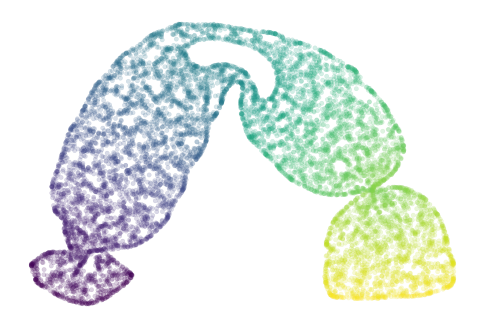

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.812140978432404), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.7813355), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.7865544450289321), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.8338453445554972), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.8625530422584605), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [11]:
pl.standard_eval(
    method="spacemap",
    dataset="scurvehole",
    params=dict(dglobal=2.0, n_neighbors=20, n_epochs=1500),
)

Slight improvement but the fundamental problem remains. Does `n_neighbors=70` help?

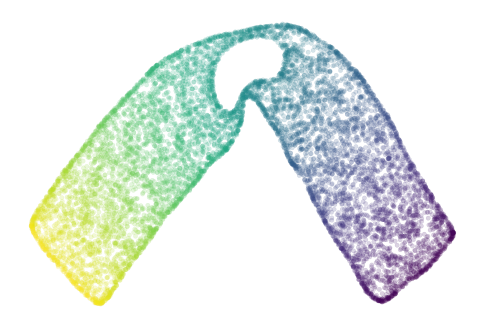

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.8462493424513414), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.82820654), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.7928739260038576), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.8642167280378749), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.9142956338769068), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [12]:
pl.standard_eval(
    method="spacemap", dataset="scurvehole", params=dict(dglobal=2.0, n_neighbors=70)
)

Yes it does. Can some further straightening occur with more optimization (the curvature is due to how the spectral initialization causing a parabolic output for these sorts of structures):

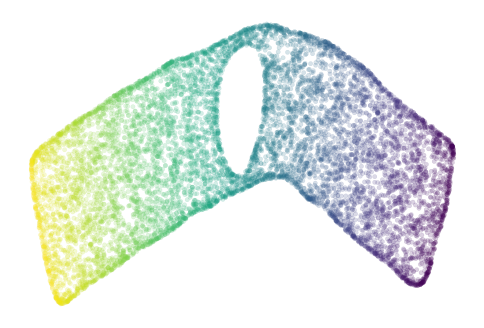

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.8665544450289322), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.86329067), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.8086059968437664), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.876471330878485), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.925934420480449), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [13]:
pl.standard_eval(
    method="spacemap",
    dataset="scurvehole",
    params=dict(dglobal=2.0, n_neighbors=70, n_epochs=1500),
)

Yeah, this is not bad. In this case, a larger value of `n_neighbors` seems important, although it will increase the run time.

## Thanks

A thank you here to Dmitry Kobak, for discussions about the SpaceMAP paper and if I understood some of the equations in there when I was hacking this together.